In [417]:
''' About this project
    This project is structured as a walk-through with a report at the end.
'''

# This project is meant to fulfill the requirements for the Udacity Nanodegree in Data Analytics
# It's not meant to do anything special. 

import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as mpl

# This is just for readability.
pd.options.display.float_format = '{:,.0f}'.format


# We'll just import a dataset. In this case it's a subset of the auto-generated ddf-gapminder--system_globalis set.
df = pd.read_csv('ddf--datapoints--total_population_with_projections--by--geo--time.csv')
# If we try to use this it's going to be messy because the data Gapminder uses is in long format, so we need to pivot it to wide format.
# This won't really format this like we want, but it's fine and readable.
df = df.pivot_table(index='geo', columns='time', values='total_population_with_projections').reset_index()

In [418]:
# That gives us 252 countries with population data from 1086 to 2100, including projections past 2013 at 2050 and 2100.
# But wait! There aren't 252 countries. So it looks like we have non-country information in this list. I want to just work with countries, so what do we do?
# Simple, we just need to see where they intersect with the iso3 country codes list.

df_country_code = pd.read_csv('country_iso_codes.csv')

df['geo'] = df['geo'].str.upper()

# I just wanted to show that we can use regular pythong for this. 
# IMO this case is just preference on small datasets where readability might be better to aim for.
# The vectorized operation took 0.00045 seconds while the loop took 0.013 seconds. 29x faster.
'''
iso3_list = list(df_country_code['CountryCode'])

for index, row in df.iterrows():
    if row['geo'] not in iso3_list:
        df.drop(index, inplace=True)
'''


df = df[df['geo'].isin(df_country_code['CountryCode'])]


df.reset_index(drop=True, inplace=True)

# and let's rename this since now we have only iso3 country codes
df.rename(columns={'geo': 'country_code'}, inplace=True)

# That should have dropped anything that's not a 3 digit country.
df.head(10)

time,country_code,1086,1100,1290,1300,1348,1349,1351,1377,1413,1450,1555,1575,1600,1630,1640,1657,1680,1700,1730,1750,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2050,2100
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"19,290",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"19,290",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"38,070","38,260","38,970","40,150","41,760","43,730","45,940","48,240","50,500","52,540","54,210","55,440","56,230","56,700","57,030","57,360","57,710","58,050","58,390","58,720","59,070","59,440","59,850","60,240","60,520","60,650","60,590","60,370","60,110","59,980","60,100","60,570","61,350","62,210","62,830","63,030","62,640","61,830","61,070","61,030","62,150","64,640","68,290","72,570","76,760","80,320","83,070","85,160","86,830","88,440","90,270","92,360","94,600","96,880","99,050","101,000","102,700","104,200","105,500","106,600","107,500","108,100","108,600","108,900","103,700","88,200"
1,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,280,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,280,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,207,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"5,730,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8,151,000","8,277,000","8,407,000","8,543,000","8,684,000","8,832,000","8,986,000","9,147,000","9,315,000","9,489,000","9,671,000","9,860,000","10,060,000","10,260,000","10,470,000","10,700,000","10,930,000","11,160,000","11,410,000","11,680,000","11,960,000","12,270,000","12,590,000","12,920,000","13,220,000","13,510,000","13,770,000","14,000,000","14,180,000","14,250,000","14,190,000","13,980,000","13,670,000","13,300,000","12,930,000","12,630,000","12,370,000","12,180,000","12,160,000","12,410,000","13,030,000","14,070,000","15,470,000","17,050,000","18,550,000","19,790,000","20

In [419]:
# Now at this point we could do a number of things, like translating the iso3 codes into country names. Or cleaning this data.
# However, given the nature of this data, cleaning like normal is going to ruin it. If we drop null columns we're going to
# Delete literally every value. Instead we want to just work with this data conditionally.

# Let's start asking some questions.
# Q: What was the population in 1950 vs 2013?
pop1950 = df[1950].sum()
pop2013 = df[2013].sum()
print(f'Population 1950: {pop1950:,.0f}')
print(f'Population 2013: {pop2013:,.0f}')

Population 1950: 2,532,527,473
Population 2013: 7,128,986,812


In [420]:
# What about the top 10 largest countries in those two years?
top10_1950 = df.nlargest(10, 1950)[['country_code', 1950]]
top10_2013 = df.nlargest(10, 2013)[['country_code', 2013]]

# Display the top 10 country codes
print(top10_1950.to_string(index=False))
print(top10_2013.to_string(index=False))

country_code        1950
         CHN 550,800,000
         IND 371,900,000
         USA 157,800,000
         RUS 102,700,000
         JPN  82,200,000
         IDN  74,840,000
         DEU  68,380,000
         BRA  53,970,000
         GBR  50,620,000
         ITA  46,370,000
country_code          2013
         CHN 1,359,000,000
         IND 1,275,000,000
         USA   318,500,000
         IDN   247,200,000
         BRA   200,100,000
         PAK   183,200,000
         NGA   170,900,000
         BGD   154,400,000
         RUS   142,600,000
         JPN   126,300,000


In [421]:
# Now let's pose an actual research question. 
# Is there a relationship between the increase or decline in a country's ranking and 
# their gini coefficient? Or put another way, have countries that have experienced lower relative growth in population experienced more or less inequality?

# For that let's add another dataset from gapminder and apply the same transformations we did earlier.

df_country_gini = pd.read_csv('ddf--datapoints--gapminder_gini--by--geo--time.csv')
df_country_gini = df_country_gini.pivot_table(index='geo', columns='time', values='gapminder_gini').reset_index()


df_country_gini['geo'] = df_country_gini['geo'].str.upper()
df_country_gini = df_country_gini[df_country_gini['geo'].isin(df_country_code['CountryCode'])]

df_country_gini.reset_index(drop=True, inplace=True)
df_country_gini.rename(columns={'geo': 'country_code'}, inplace=True)

In [422]:
df_country_gini.head(3)

time,country_code,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,AFG,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,31,31,31,31,32,32,32,33,34,34,35,36,37,38,39,40,40,42,42,43,44,45,46,46,47,47,47,47,47,47,47,46,46,45,45,44,43,43,42,41,41,40,40,39,39,38,38,38,38,38,38,38,38,38,39,39,39,40,40,40,40,41,41,41,41,42,42,42,42,42,41,41,41,41,41,40,40,40,40,39,39,39,39,38,38,38,38,38,37,37,37,37,36,36,36,36,36,36,35,35,35,35,34,34,34,34,34,34,34,34,34,34,34,35,35,34,34,34,34,33,33,32,32,31,31,30,30,31,31,32,32,32,32,32,32,32,32,32,32,32,32,33,34,35,35,36,36,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
1,AGO,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,56,56,56,56,55,55,55,54,54,54,53,53,53,52,52,52,51,51,51,50,50,50,49,49,49,48,48,48,47,47,47,46,46,46,45,45,45,44,44,44,43,43,43,42,42,42,41,41,41,40,40,40,39,39,39,38,38,38,37,37,37,36,36,36,36,36,36,36,36,36,36,36,37,37,38,38,39,40,40,41,42,43,43,44,45,45,46,47,48,48,49,50,50,51,52,53,53,54,55,56,56,57,58,58,59,60,60,60,60,61,61,61,61,61,60,60,60,60,59,59,59,59,58,58,58,58,57,57,57,57,57,56,56,56,56,56,56,56,56,56,56,56,55,55,55,55,55,55,55,55,55,54,54,54,54,54,54,54,54,54,54,54,54,53,53,53,53,53,53,53,53,53,53,52,52,52,52,52,52,51,51,50,48,47,46,45,44,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
2,ALB,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,38,38,38,38,37,37,37,36,36,35,34,34,33,33,32,31,31,30,30,29,29,28,28,28,27,27,27,27,27,27,27,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,28,28,29,29,30,31,31,31,31,31,30,30,30,30,30,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29


In [423]:
df.head(3)

time,country_code,1086,1100,1290,1300,1348,1349,1351,1377,1413,1450,1555,1575,1600,1630,1640,1657,1680,1700,1730,1750,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2050,2100
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"19,290",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"19,290",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"38,070","38,260","38,970","40,150","41,760","43,730","45,940","48,240","50,500","52,540","54,210","55,440","56,230","56,700","57,030","57,360","57,710","58,050","58,390","58,720","59,070","59,440","59,850","60,240","60,520","60,650","60,590","60,370","60,110","59,980","60,100","60,570","61,350","62,210","62,830","63,030","62,640","61,830","61,070","61,030","62,150","64,640","68,290","72,570","76,760","80,320","83,070","85,160","86,830","88,440","90,270","92,360","94,600","96,880","99,050","101,000","102,700","104,200","105,500","106,600","107,500","108,100","108,600","108,900","103,700","88,200"
1,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,280,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,280,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,207,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"5,730,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8,151,000","8,277,000","8,407,000","8,543,000","8,684,000","8,832,000","8,986,000","9,147,000","9,315,000","9,489,000","9,671,000","9,860,000","10,060,000","10,260,000","10,470,000","10,700,000","10,930,000","11,160,000","11,410,000","11,680,000","11,960,000","12,270,000","12,590,000","12,920,000","13,220,000","13,510,000","13,770,000","14,000,000","14,180,000","14,250,000","14,190,000","13,980,000","13,670,000","13,300,000","12,930,000","12,630,000","12,370,000","12,180,000","12,160,000","12,410,000","13,030,000","14,070,000","15,470,000","17,050,000","18,550,000","19,790,000","20

In [424]:
# and now, given the scope of our data, we need to do one final bit of cleaning to make it so we can run a regression analysis on it
# running an intersection on the years and countries to produce a dataset that matches. We still don't want to drop null values, though.
# we'll handle null values in our new dataframes.

# first we'll do this so we don't destroy our original data
dfpop = df
dfgini = df_country_gini

common_columns = list(set(dfpop.columns) & set(dfgini.columns))
common_country_codes = list(set(dfpop['country_code']) & set(dfgini['country_code']))

dfpop = dfpop[dfpop['country_code'].isin(common_country_codes)][common_columns]
dfgini = dfgini[dfgini['country_code'].isin(common_country_codes)][common_columns]

#Now we need to reset the indexes since we've dropped lots of rows.
dfpop.reset_index(drop=True, inplace=True)
dfgini.reset_index(drop=True, inplace=True)

dfpop.info()
print()
dfgini.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 215 entries, country_code to 2013
dtypes: float64(214), object(1)
memory usage: 326.0+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 215 entries, country_code to 2013
dtypes: float64(214), object(1)
memory usage: 326.0+ KB


In [425]:
# now we need ot handle null values in our population data.
# we can see that we don't have any null gini information, but we do have *lots* of null population information
popnull = dfpop.isnull().values.any()
gininull = dfgini.isnull().values.any()
print(f'Pop Nulls: {popnull}')
print(f'Gini Nulls: {gininull}')


Pop Nulls: True
Gini Nulls: False


In [426]:
# but before we go creating a regression to fill things not just with values on either side, but all one-sided, let's make sure we
# don't have information in 1800 for every remaining country. We can assume that every country has at least one population
# value on the right side of the dataset.

nulls_1800 = dfpop[1800].isnull().any()
print(f'1800 Has Nulls: {nulls_1800}')

1800 Has Nulls: False


In [427]:
# That's great. That really simplifies this next step where we create usable artificial data.
# finally we get to use numpy and an algorithm. It would probably be better to use scipy.stats' lineregress here, but w/e
# first we'll define a function to fill these extents

def nullFill(start, stop, row):
    start_value, start_i = start
    end_value, end_i = stop
    # get out list of null years
    null_years = row.index[start_i:end_i]
    # now we run our regression. I'm not going to explain this here
    x = np.array([start_i - 1, end_i + 1])
    y = np.array([start_value, end_value])
    coefficients = np.polyfit(x, y, deg=1)
    null_values = np.polyval(coefficients, np.arange(start_i, end_i))
    
    row[null_years] = null_values
    return row


# now let's go through out dataset finding null extents and fill ing them.
for index, row in dfpop.iterrows():
    for i, value in enumerate(row):
        # if the value is null but the previous value isn't, we've found a null extent.
        if pd.isnull(value) and not pd.isnull(row.values[i - 1]):
            nullExStart = (row.values[i - 1], i)
        # find the end of the null extent
        if not pd.isnull(value) and pd.isnull(row.values[i - 1]):
            nullExEnd = (row.values[i], i)
            # now that we have our end, we can handle the extent
            dfpop.loc[index] = nullFill(nullExStart, nullExEnd, row)

dfpop.head(10)


time,country_code,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,AFG,"3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,298,176","3,316,353","3,334,529","3,352,706","3,370,882","3,389,059","3,407,235","3,425,412","3,443,588","3,461,765","3,479,941","3,498,118","3,516,294","3,534,471","3,552,647","3,570,824","3,589,000","3,607,176","3,625,353","3,643,529","3,661,706","3,679,882","3,698,059","3,716,235","3,734,412","3,752,588","3,770,765","3,788,941","3,807,118","3,825,294","3,843,471","3,861,647","3,879,824","3,898,000","3,916,176","3,934,353","3,952,529","3,970,706","3,988,882","4,007,059","4,025,235","4,043,412","4,061,588","4,079,765","4,097,941","4,116,118","4,134,294","4,152,471","4,170,647","4,207,000","4,241,614","4,276,227","4,310,841","4,345,455","4,380,068","4,414,682","4,449,295","4,483,909","4,518,523","4,553,136","4,587,750","4,622,364","4,656,977","4,691,591","4,726,205","4,760,818","4,795,432","4,830,045","4,864,659","4,899,273","4,933,886","4,968,500","5,003,114","5,037,727","5,072,341","5,106,955","5,141,568","5,176,182","5,210,795","5,245,409","5,280,023","5,314,636","5,349,250","5,383,864","5,418,477","5,453,091","5,487,705","5,522,318","5,556,932","5,591,545","5,626,159","5,660,773","5,730,000","5,793,711","5,857,421","5,921,132","5,984,842","6,048,553","6,112,263","6,175,974","6,239,684","6,303,395","6,367,105","6,430,816","6,494,526","6,558,237","6,621,947","6,685,658","6,749,368","6,813,079","6,876,789","6,940,500","7,004,211","7,067,921","7,131,632","7,195,342","7,259,053","7,322,763","7,386,474","7,450,184","7,513,895","7,577,605","7,641,316","7,705,026","7,768,737","7,832,447","7,896,158","7,959,868","8,023,579","8,151,000","8,277,000","8,407,000","8,543,000","8,684,000","8,832,000","8,986,000","9,147,000","9,315,000","9,489,000","9,671,000","9,860,000","10,060,000","10,260,000","10,470,000","10,700,000","10,930,000","11,160,000","11,410,000","11,680,000","11,960,000","12,270,000","12,590,000","12,920,000","13,220,000","13,510,000","13,770,000","14,000,000","14,180,000","14,250,000","14,190,000","13,980,000","13,670,000","13,300,000","12,930,000","12,630,000","12,370,000","12,180,000","12,160,000","12,410,000","13,030,000","14,070,000","15,470,000","17,050,000","18,550,000","19,790,000","20,680,000","21,300,000","21,750,000","22,230,000","22,860,000","23,680,000","24,640,000","25,680,000","26,690,000","27,610,000","28,420,000","29,150,000","29,840,000","30,580,000","31,410,000","32,360,000","33,400,000","34,500,000"
1,AGO,"1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,584,942","1,602,884","1,6

In [433]:
# now we have what should be two nice and complete little datasets with reasonably interpolated synthetic datapoints in place of the null values.
# Now let's see if there's any correlation between inequality and a country's calculated rank in a given year.
# Go ahead and give me the start years.

# hint: enter numbers between 1800 and 2013
while True:
    start_year = int(input("Enter the start year: "))
    end_year = int(input("Enter the end year: "))
    if start_year < end_year and start_year >= dfpop.columns[1] and end_year <= dfpop.columns[-1]:
        break

Enter the start year:  1900
Enter the end year:  2013


In [434]:
# Now we can finally start our analysis
# this gives us countries ranked by population
start_rank = dfpop[start_year].rank(ascending=False, method='min')
print(start_rank)
# This grabs us the change in a country's rank in population.
change_in_rank = dfpop[end_year].rank(ascending=False, method='min') - start_rank
print(change_in_rank)

0      39
1      64
2     118
3     192
4     171
       ..
189   179
190    63
191    42
192   121
193    82
Name: 1900, Length: 194, dtype: float64
0       0
1      -6
2      15
3      -8
4     -77
       ..
189    -4
190   -16
191   -18
192   -52
193   -11
Length: 194, dtype: float64


In [435]:
# Now we'll grab the mean gini coefficient during that time. Yes, we could do a more advanced analysis but this is ultimately just an overdone
# assignment.

gini_columns = list(range(start_year, end_year))
gini_coefficients = dfgini[gini_columns].mean(axis=1)

In [436]:
# Now we can actually run some tests on these.

correlation_start_rank_change = np.corrcoef(start_rank, change_in_rank)[0, 1]
correlation_start_rank_gini = np.corrcoef(start_rank, gini_coefficients)[0, 1]
correlation_change_in_rank_gini = np.corrcoef(change_in_rank, gini_coefficients)[0, 1]

print("Correlation between starting rank and change in rank:", correlation_start_rank_change)
print("Correlation between starting rank and Gini coefficient:", correlation_start_rank_gini)
print("Correlation between change in rank and Gini coefficient:", correlation_change_in_rank_gini)

Correlation between starting rank and change in rank: -0.21205374900560614
Correlation between starting rank and Gini coefficient: 0.22611851404693792
Correlation between change in rank and Gini coefficient: -0.49202318633221725


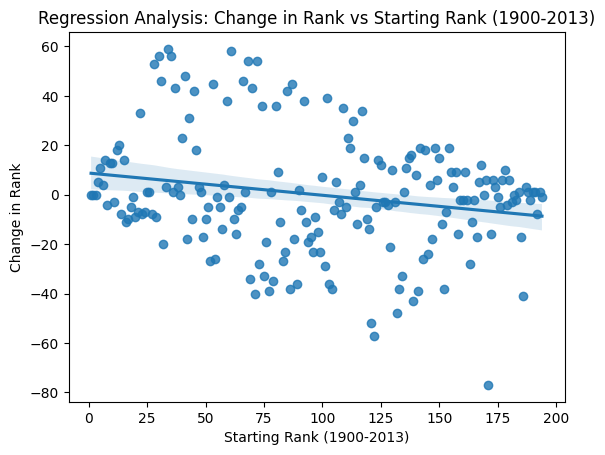

In [443]:
# Now, we could move on to other angles of analysis from here to understand these relationships. For example:
# Making a regression showing the relationship between start and end rank.
sbn.regplot(x=start_rank, y=change_in_rank)
mpl.xlabel(f'Starting Rank ({start_year}-{end_year})')
mpl.ylabel("Change in Rank")
mpl.title(f'Regression Analysis: Change in Rank vs Starting Rank ({start_year}-{end_year})')
mpl.show()

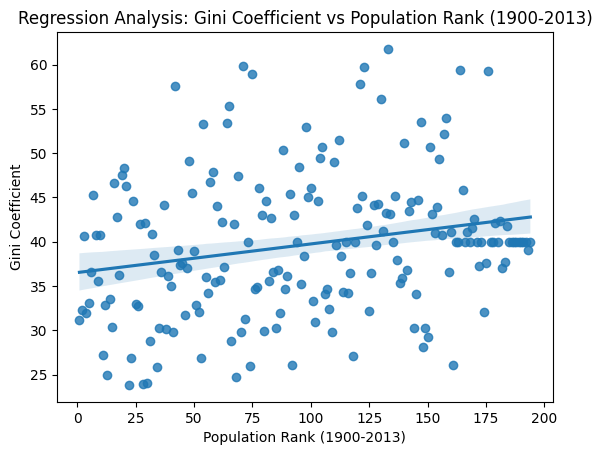

In [444]:
# or start rank and gini
sbn.regplot(x=start_rank, y=gini_coefficients)

mpl.xlabel(f'Population Rank ({start_year}-{end_year})')
mpl.ylabel("Gini Coefficient")
mpl.title(f'Regression Analysis: Gini Coefficient vs Population Rank ({start_year}-{end_year})')
mpl.show()


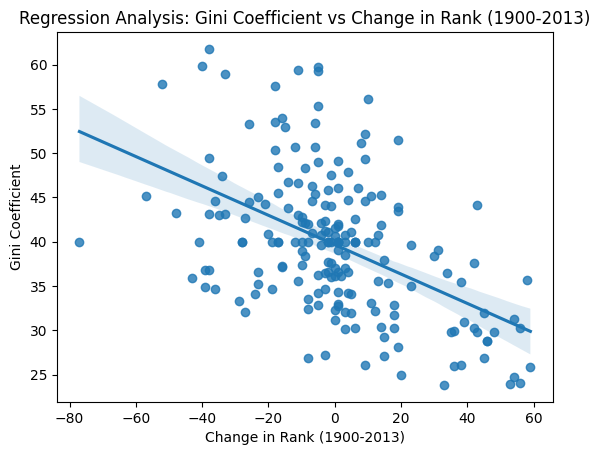

In [445]:
# or change in rank vs gini
sbn.regplot(x=change_in_rank, y=gini_coefficients)

mpl.xlabel(f'Change in Rank ({start_year}-{end_year})')
mpl.ylabel("Gini Coefficient")
mpl.title(f'Regression Analysis: Gini Coefficient vs Change in Rank ({start_year}-{end_year})')
mpl.show()

In [ ]:
# Alright we have some results!
# This will be the report sections!
'''
    Research Question:
        Is there a correlation between a country's relative population size to other countries and its level of inequality?
        For this writeup we'll test 1800 to 2013.
    
    Results:
        How should we interpret these results?
            Remember that negative numbers indicate a negative relationship, 0 no relationship, and positive a positive relationship.
            Positive: as one thing increases the latter thing increases (rank change up, gini up)
            Zero:     no relatinship
            Negatie:  as one thing increases the latter thing decreases (rank change up, gini down)

        Let's go over them, then.
            * Correlation between starting rank and change in rank: -0.23758802477608323
                This indicates that higher starting ranks correlated with bigger drops in rank and vice versa.

            * Correlation between starting rank and Gini coefficient: 0.16377049446028172
                This indicated that bigger countries in 1800 tended to have more inequality going forward.

            * Correlation between change in rank and Gini coefficient: -0.3697287095169644
                This indicated that countries with higher positive changes in rank experienced lower inequality.
    
    Discussion:
        There are likely a lot of reasons why our results look the way they do. First off, inequality is not a perfect
        measurement of economic success. Poor countries tend to have low inequality where rich countries tend to have
        a much higher level of it. However, the poor in rich countries are typically better off than 
        even the rich in poor countries.
        
        I tested three hypotheses here, and found clear patterns in each. Likewise, if you restrict the timescale to 
        1900-2013 the correlations actually grow as we have less flat-synthetic data in the gini dataset.
        Overall the 
        
    Further efforts:
        At this point the next research step would be to run many correlations and perform an analysis of statistical
        power in r-studio or something else.
        
        More graphs could also be produced, but the nature of my research question here is not condusive to those being useful.
        From here the natural steps would be to break the data down by region (easily done given I used iso3 codes) and do
        separate analyses of regions, cultures, etc. Adding additional data onto these sets is very easily done.
        
'''
